In [90]:
from matplotlib import pyplot as plt
from ietk import methods
from ietk import util
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pydicom

In [91]:
def find_files(folder_path):
    """
    Recursively find all files in a folder and its subfolders.
    
    Args:
    - folder_path (str): Path to the folder to search.
    
    Returns:
    - file_paths (list): List of paths to all files found.
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [92]:
ses_dir = 'databases/SES'
#get filepaths for all files in that directory and subdirectories
ses_paths = find_files(ses_dir)


In [93]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
model_type = "vit_t"
sam_checkpoint = "./mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

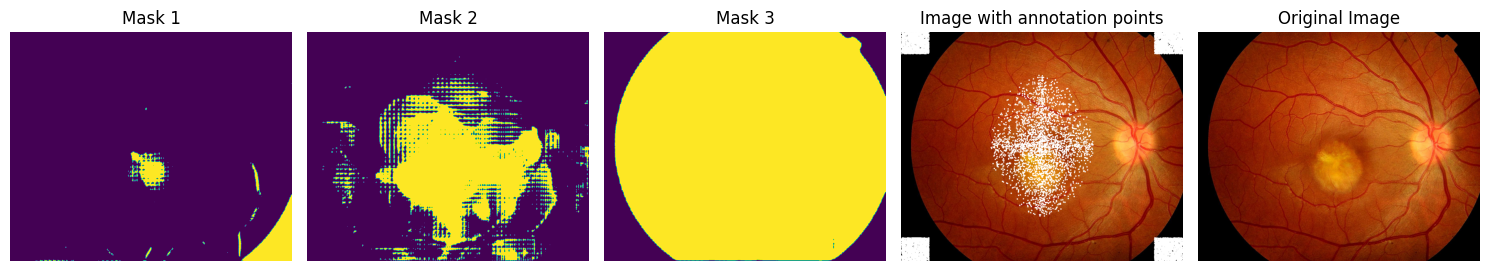

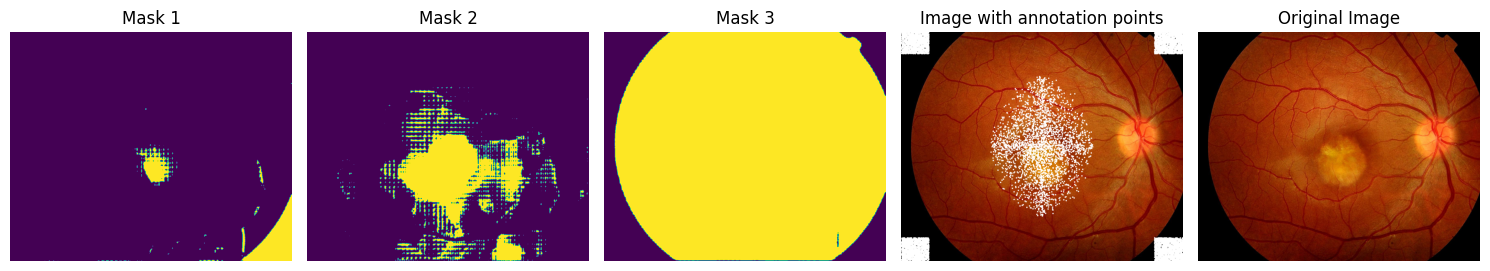

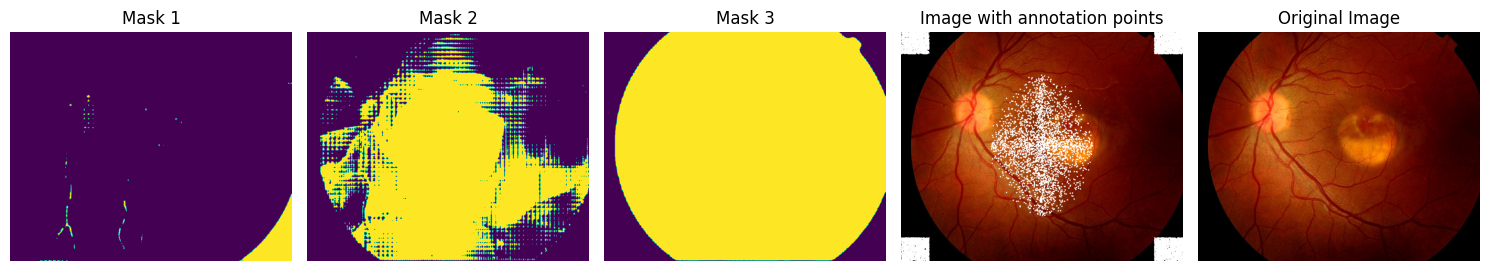

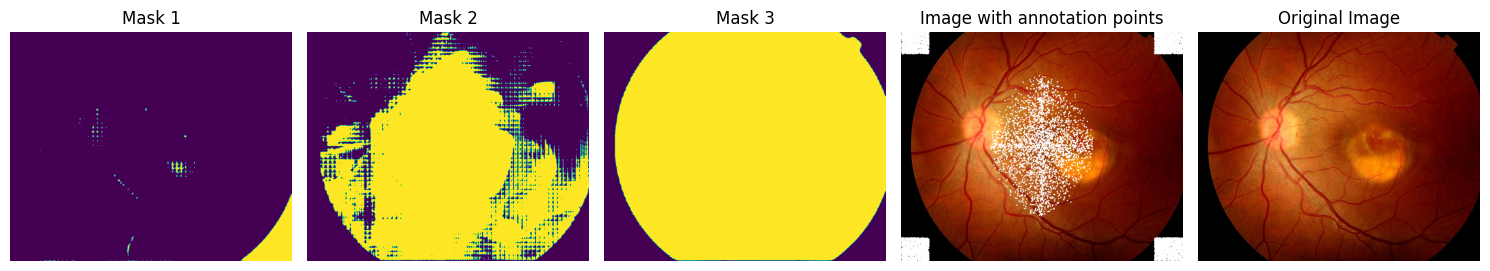

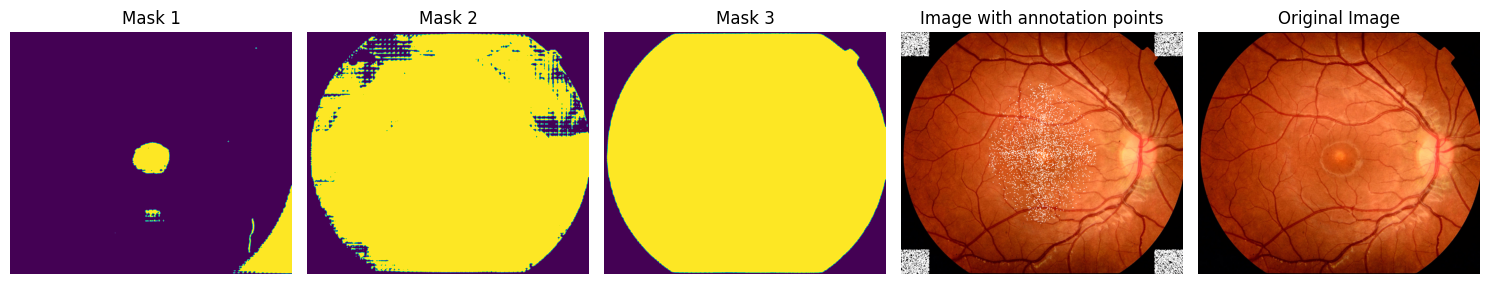

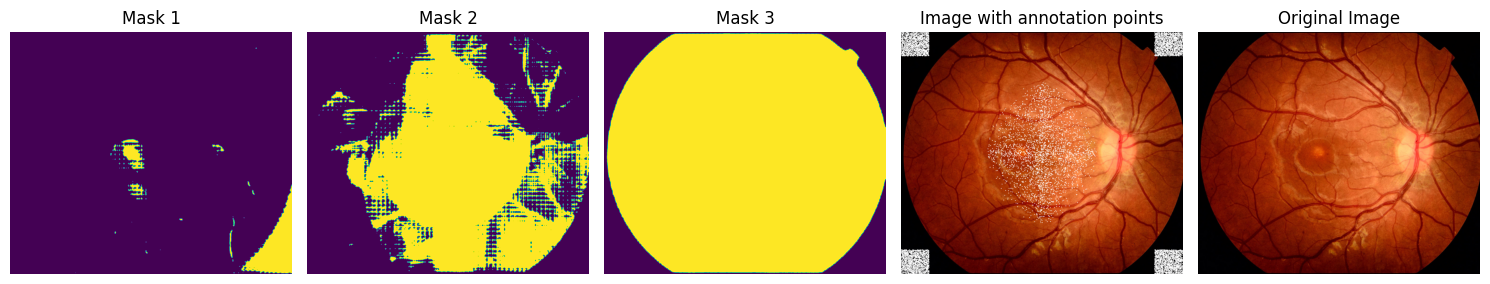

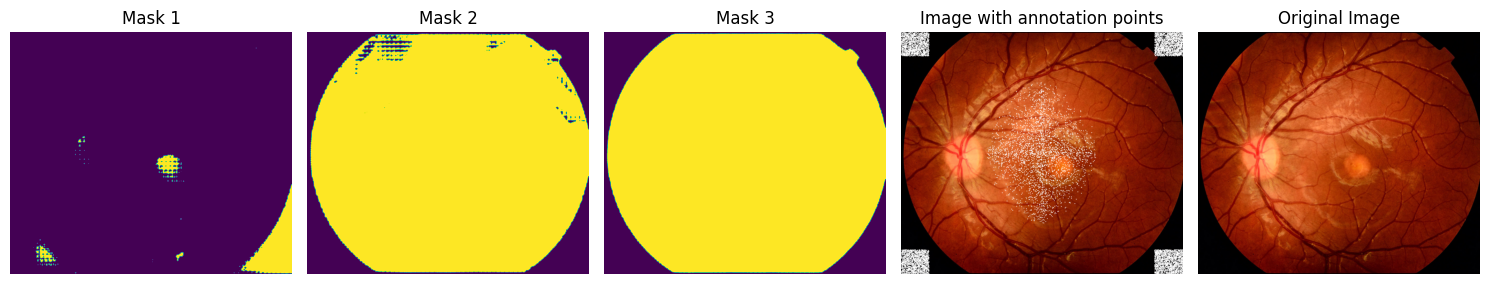

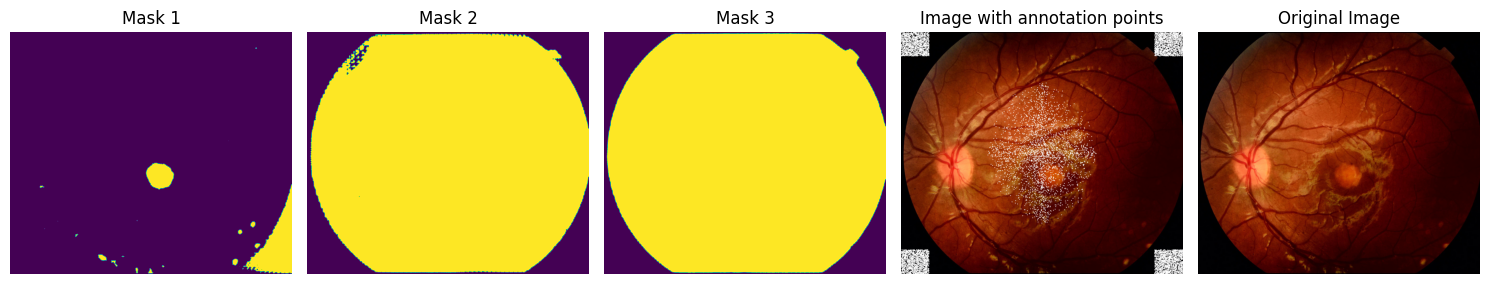

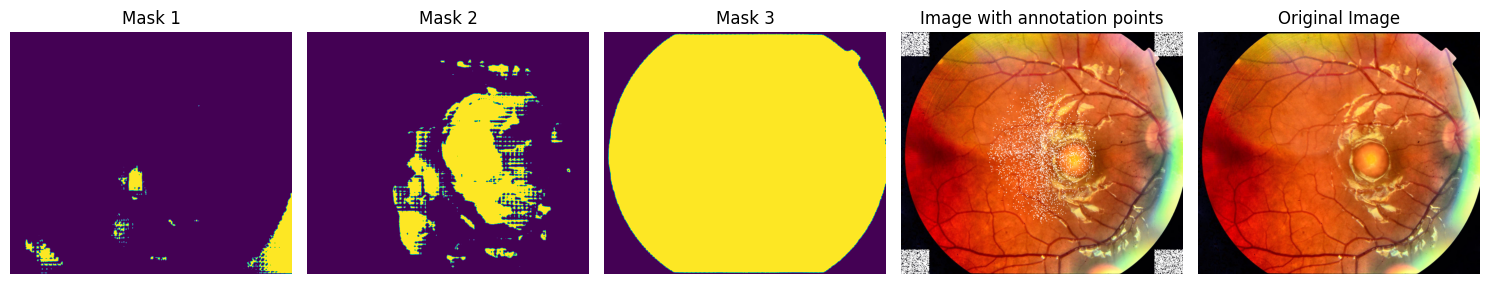

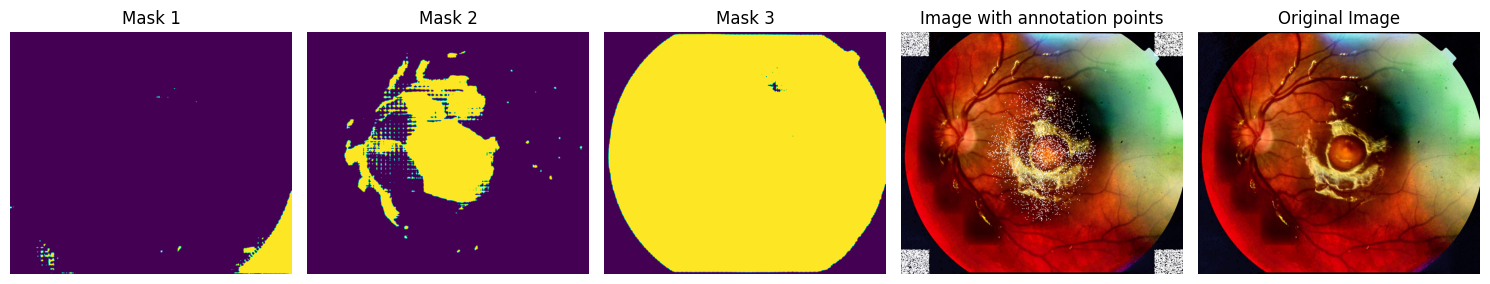

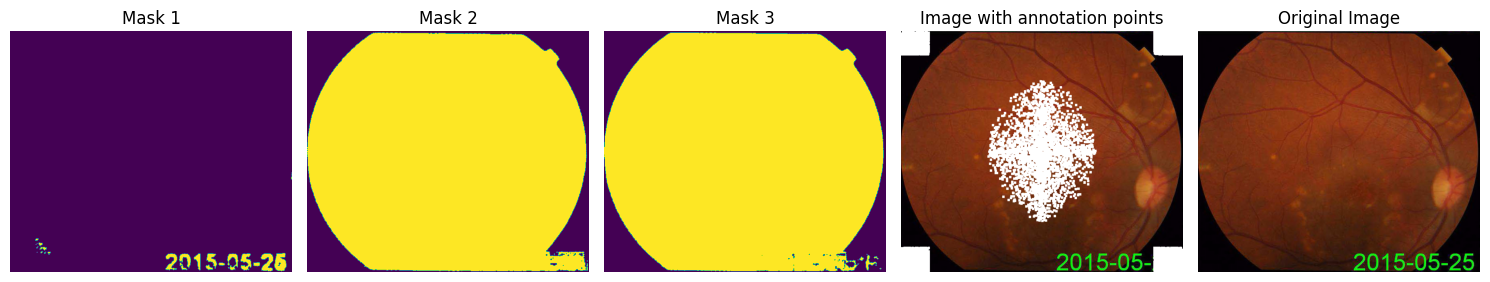

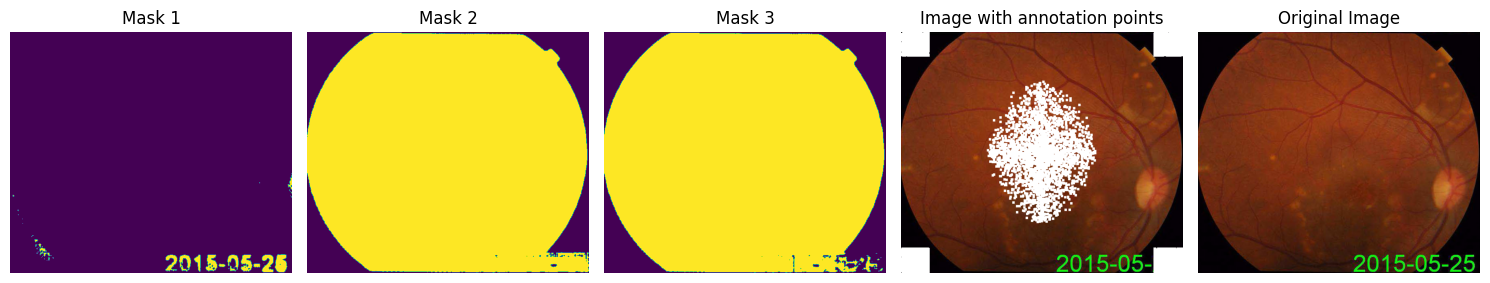

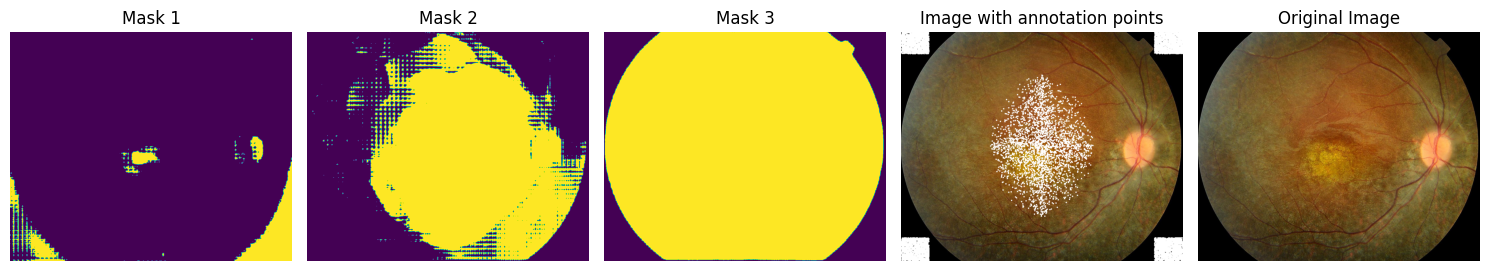

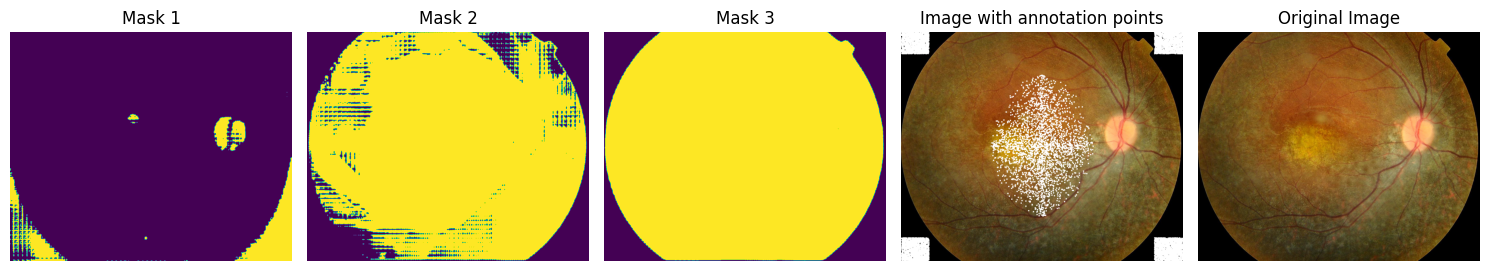

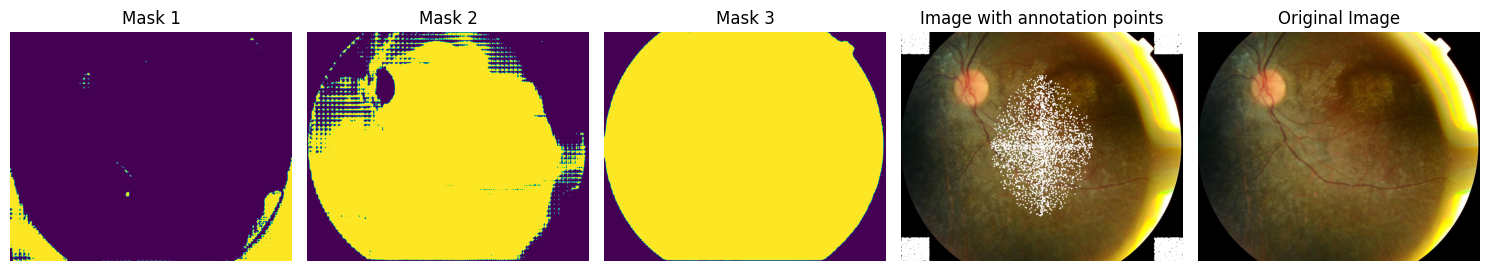

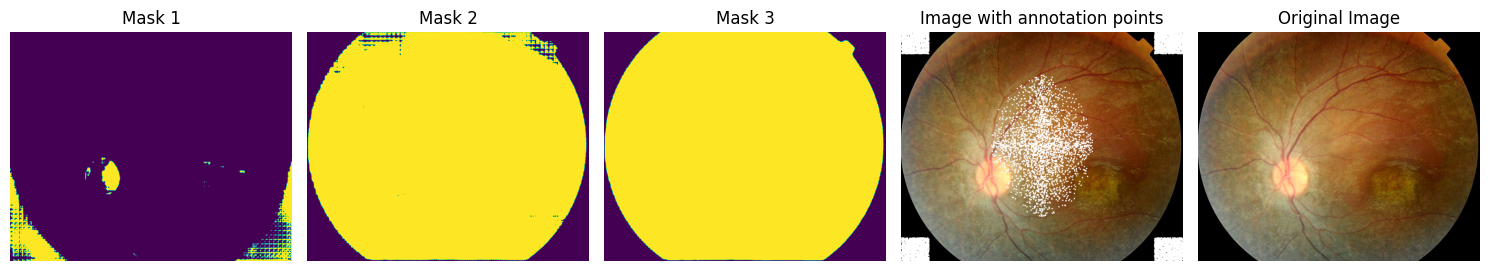

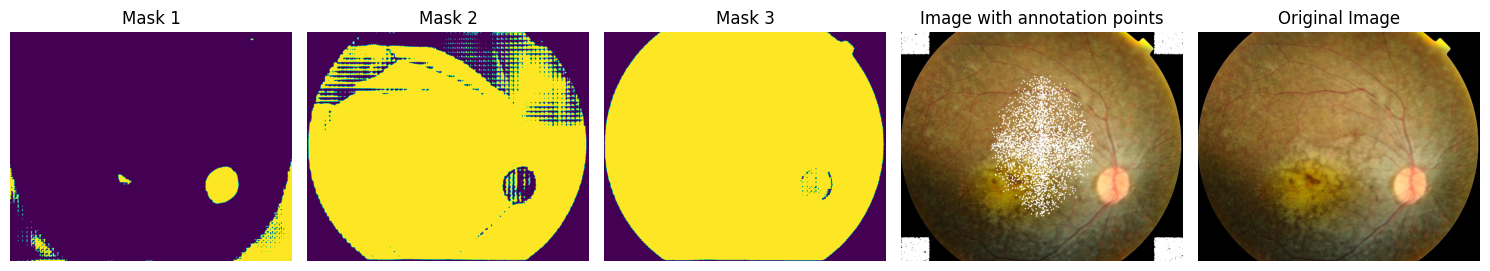

KeyboardInterrupt: 

In [95]:

predictor = SamPredictor(mobile_sam)
for i, path in enumerate(ses_paths):
    #open the image
    img = Image.open(path).convert('RGB')
    img_arr = np.array(img)
    #convert to numpy array
    #set the bbox to the middle of the image
    x_top_left = img_arr.shape[1] // 4
    y_top_left = img_arr.shape[0] // 4
    x_bottom_right = 3 * img_arr.shape[1] // 4
    y_bottom_right = 3 * img_arr.shape[0] // 4
    #get the middle of the image
    x_center = img_arr.shape[1] // 2
    y_center = img_arr.shape[0] // 2
    input_label = []
    center_points = []
    #randomly add points to the image which are in a circle around the center with a radius of 3% of the image size
    max_radius_x = int(0.45 * (img_arr.shape[0]) / 2)
    max_radius_y = int(0.50 * (img_arr.shape[1]) / 2)
    for j in range(3000):
        radius_x = np.random.random() * max_radius_x
        radius_y = np.random.random() * max_radius_y
        angle = np.random.rand() * 2 * np.pi
        x = int(x_center + radius_x * np.cos(angle))
        y = int(y_center + radius_y * np.sin(angle))
        input_label.append(1)
        center_points.append([x, y])
    #label all 4 corners of the image as background
    #also add points which are close to the border of the image
    corner_offset = 0.10
    for j in range(2000):
        x_close_r_bottom = np.random.randint(int(img_arr.shape[1] * (1 - corner_offset)), img_arr.shape[1])
        y_close_r_bottom = np.random.randint(int(img_arr.shape[0] * (1 - corner_offset)), img_arr.shape[0])
        x_close_r_top = np.random.randint(int(img_arr.shape[1] * (1 - corner_offset)), img_arr.shape[1])
        y_close_r_top = np.random.randint(0, int(img_arr.shape[0] * corner_offset))
        x_close_l_bottom = np.random.randint(0, int(img_arr.shape[1] * corner_offset))
        y_close_l_bottom = np.random.randint(int(img_arr.shape[0] * (1 - corner_offset)), img_arr.shape[0])
        x_close_l_top = np.random.randint(0, int(img_arr.shape[1] * corner_offset))
        y_close_l_top = np.random.randint(0, int(img_arr.shape[0] * corner_offset))
        input_label.extend([4, 4, 4, 4])
        center_points.extend([[x_close_l_top, y_close_l_top], [x_close_r_top, y_close_r_top], [x_close_l_bottom, y_close_l_bottom], [x_close_r_bottom, y_close_r_bottom]])


    #convert to numpy array
    input_label = np.array(input_label)
    center_points = np.array(center_points)
    predictor.set_image(img_arr)
    masks, _, _ = predictor.predict(point_coords=center_points, point_labels=input_label)
    #show all masks next to each other
    # Plot each mask
    fig, axes = plt.subplots(1, len(masks) + 2, figsize=(15, 5))

    for j, ax in enumerate(axes[:-2]):
        ax.imshow(masks[j])
        ax.set_title(f'Mask {j+1}')
        ax.axis('off')

    # Plot the original image with points
    img_with_points = img_arr.copy()
    for point in center_points:
        x, y = point
        img_with_points[y-3:y+3, x-3:x+3] = [255, 255, 255]  # Assuming img_arr is in [0, 1] range

    axes[-2].imshow(img_with_points)
    axes[-2].set_title('Image with annotation points')
    axes[-2].axis('off')

    # Plot the original image
    axes[-1].imshow(img_arr)
    axes[-1].set_title('Original Image')
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()
    if i > 100:
        break
    